In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Inspect tables

In [9]:
from sqlalchemy import inspect

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [11]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set
from sqlalchemy import desc
most_recent_date = session.query(Measurement).order_by(desc(Measurement.date)).first()
print(most_recent_date.date)

2017-08-23


2017-08-23
2016-08-23
            prcp
date            
2016-08-23  0.00
2016-08-23  0.15
2016-08-23  0.05
2016-08-23  0.02
2016-08-23  1.79
...          ...
2017-08-22  0.50
2017-08-23  0.00
2017-08-23  0.00
2017-08-23  0.08
2017-08-23  0.45

[2021 rows x 1 columns]
6.7


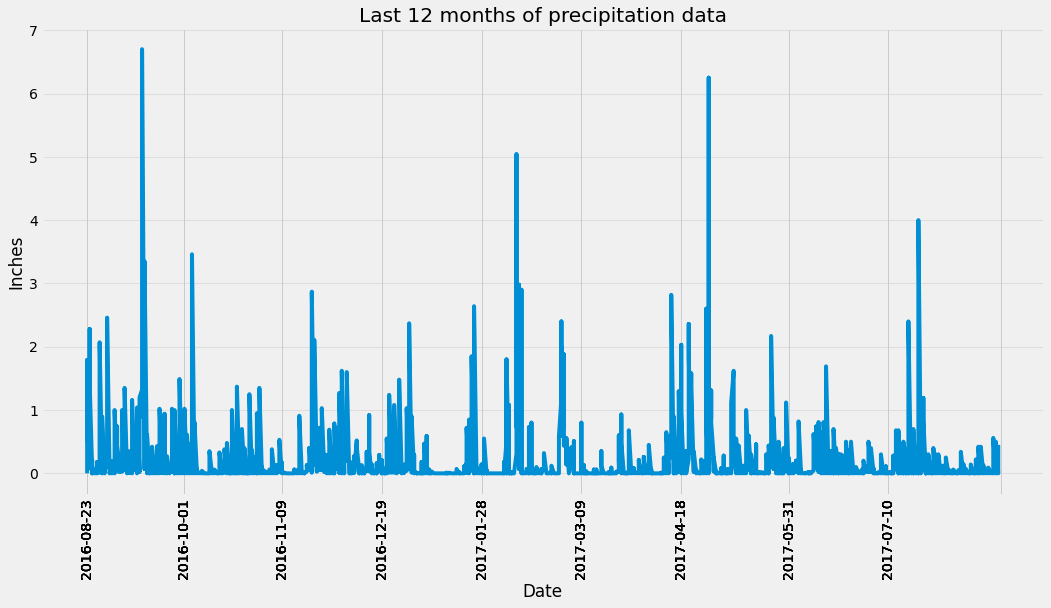

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt
from datetime import datetime

recent_date = datetime.strptime(most_recent_date.date, '%Y-%m-%d').date()
print(recent_date)

# Calculate the date one year from the last date in data set.
year_ago = recent_date - dt.timedelta(days=365)
print(year_ago)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.date <= recent_date).\
    order_by(Measurement.date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.read_sql_query(precipitation, session.bind)
precipitation_df = precipitation_df.dropna()
precipitation_df = precipitation_df.set_index('date')
print(precipitation_df)

print(precipitation_df['prcp'].max())
    
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = precipitation_df.index.to_list()
y_axis = precipitation_df['prcp'].to_list()
plt.figure(figsize=(16,8))
plt.plot(x_axis, y_axis)

labels = ['2016-08-23', '2016-10-01', '2016-11-09', '2016-12-19', '2017-01-28', '2017-03-09', '2017-04-18', '2017-05-31', '2017-07-10']
new_x = []
for date in x_axis:
    if date in labels:
        value = date
    else:
        value = ''
    new_x.append(value)

plt.grid(which='major', alpha=0.5)
plt.xticks(new_x, rotation = 90)
plt.title('Last 12 months of precipitation data')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.savefig('Outputs/PrecipitationGraph.png')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(Station.name).count()
print(f"The total number of stations is {stations}")

The total number of stations is 9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station).\
              label('total')).group_by(Measurement.station).order_by(desc('total')).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = session.query(Measurement.station, func.count(Measurement.station).\
              label('total')).group_by(Measurement.station).order_by(desc('total')).first()

most_active_station

('USC00519281', 2772)

In [21]:
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, -1.340000000000014, 'Temperature')

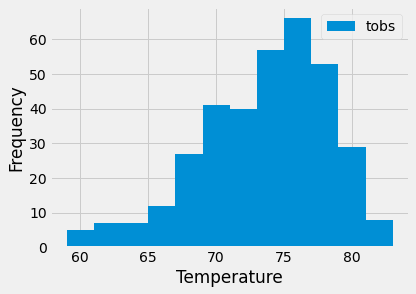

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= year_ago).all()
info = pd.DataFrame(results, columns=['tobs'])
info.plot.hist(bins=12)
plt.tight_layout()
plt.xlabel("Temperature")

# Close session

In [ ]:
# Close Session
session.close()